## 1. 环境准备

In [1]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer, PostProcessingPipeline
from src.custom_ocr.processors import TopKDecoder, CTCDeduplicator, ConfidenceFilter

print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 模块导入成功
✓ Matplotlib 中文支持已配置


## 2. 初始化识别器

In [2]:
# 初始化自定义识别器
recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'  # 如果没有 GPU,改为 'cpu'
)

print("\n模型信息:")
model_info = recognizer.get_model_info()
for key, value in model_info.items():
    print(f"  {key}: {value}")

Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_cnn64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_precompiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_runtime_compiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_heuristic64_9.dll" or one of its dependencies.
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0

模型信息:
  model_name: PP-OCRv5_server_rec
  num_characters: 18385
  blank_index: 0
  preprocessors: ['Read', 'ReisizeNorm', 'ToBatch']


## 3. 加载测试数据 + 图像裁剪

**【修改点】**: 从原图开始,调用裁剪函数生成temp_cropped.png

In [ ]:
from pathlib import Path
import re
from PIL import Image

# 项目根目录
project_root = Path('..').resolve()

# ========== 【新增】图像裁剪步骤 ==========
print("【步骤0: 图像裁剪】")
print("="*80)

# 导入裁剪模块
from src.pipeline.image_cropper import crop_image, CROP_REGIONS

# 原始图像路径
raw_img_path = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_04_01.png'
print(f"原始图像: {raw_img_path}")

# 判断使用哪个裁剪区域
filename = raw_img_path.name
match = re.search(r'_0(\d)\.png$', filename)

if match:
    page_num = int(match.group(1))
    print(f"检测到页码: {page_num}")
    
    if page_num in [1, 3]:
        crop_region = CROP_REGIONS['page1']
        region_name = 'page1'
    elif page_num in [2, 4]:
        crop_region = CROP_REGIONS['page2']
        region_name = 'page2'
    else:
        crop_region = None
        region_name = '无裁剪'
else:
    print("⚠️  无法从文件名提取页码,使用原图")
    crop_region = None
    region_name = '无裁剪'

print(f"使用裁剪区域: {region_name}")

# 执行裁剪或使用原图
if crop_region:
    cropped_img = crop_image(raw_img_path, crop_region)
    print(f"✓ 裁剪完成: {cropped_img.size}")
    print(f"  裁剪区域: {crop_region}")
else:
    cropped_img = Image.open(raw_img_path)
    print(f"✓ 使用原图: {cropped_img.size}")
    print(f"  无需裁剪")

# 保存图像
temp_cropped_path = project_root / 'output' / f'temp_cropped_{raw_img_path.stem}.png'
cropped_img.save(temp_cropped_path)
print(f"✓ 保存图像: {temp_cropped_path}")
print()

# ========== 【以下与02.8相同】加载图像和GT ==========
# 1. 加载图像
img_path = temp_cropped_path
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}\n请确保文件存在")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth(读取为字符串)
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_04_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

print(f"✓ 加载 Ground Truth: {len(ground_truth)} 字符")

# 3. 清理 ground truth(移除 <insert></insert> 和 <?> 标记,移除换行和空格)
gt_clean = re.sub(r'<insert>|</insert>|<\?>', '', ground_truth)
gt_clean = gt_clean.replace('\n', '').replace(' ', '')

print(f"✓ 清理后的 Ground Truth: {len(gt_clean)} 字符")
print(f"前 100 字符: {gt_clean[:100]}")


【步骤0: 图像裁剪】
原始图像: C:\Users\Quenton\Documents\Github\writtingOCR\data\samples\2022 第2題 (冬奧) (8份)_Original\sample_04_01.png
✓ 裁剪完成: (2170, 2900)
  裁剪区域: {'x_start': 150, 'y_start': 360, 'x_end': 2320, 'y_end': 3260}
✓ 保存裁剪图像: C:\Users\Quenton\Documents\Github\writtingOCR\output\temp_cropped_04_01.png

✓ 加载图像: (2900, 2170, 3)
✓ 加载 Ground Truth: 476 字符
✓ 清理后的 Ground Truth: 432 字符
前 100 字符: 第二題致滑雪總會余主席：「香港與冬奧」本人為一名香港業餘滑雪愛好者。有鑒於是次北京冬奧會，中國香港代表團史無前例地派出三名運動員出戰，雖然中沒有獲獎，但其體育精神令我大爲感動。因此，我特意來涵望貴會延


## 3.1 格子检测与分割

从 src.preprocessing 导入格子检测方法

In [4]:
# 从 src.preprocessing 导入格子检测方法
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells

# 转换为灰度图(detect_grid_lines 需要灰度图)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(image=gray, min_length=300)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像(改进版:裁剪中心区域 + 提升阈值)
print("\n过滤非空格子并裁剪...")
cell_images = []
non_empty_cells = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    # 判断是否为非空格子
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域(避免边框干扰)
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)  # 裁剪 8%
        if h > 2*crop and w > 2*crop:  # 确保裁剪后还有内容
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell  # 格子太小,不裁剪
        
        # 计算中心区域的非白色像素比例
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:  # 超过0.5%的非白色像素认为是非空
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ 非空格子数: {len(cell_images)}")
print(f"✓ Ground Truth 字符数: {len(gt_clean)}")

检测格子线...
✓ 检测到横线: 213 条
✓ 检测到竖线: 165 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 434
✓ Ground Truth 字符数: 432


## 3.2 可视化部分格子(可选)

可视化格子网格布局...
网格大小: 29 行 × 20 列
总格子数: 580
非空格子数: 434
空格子数: 146


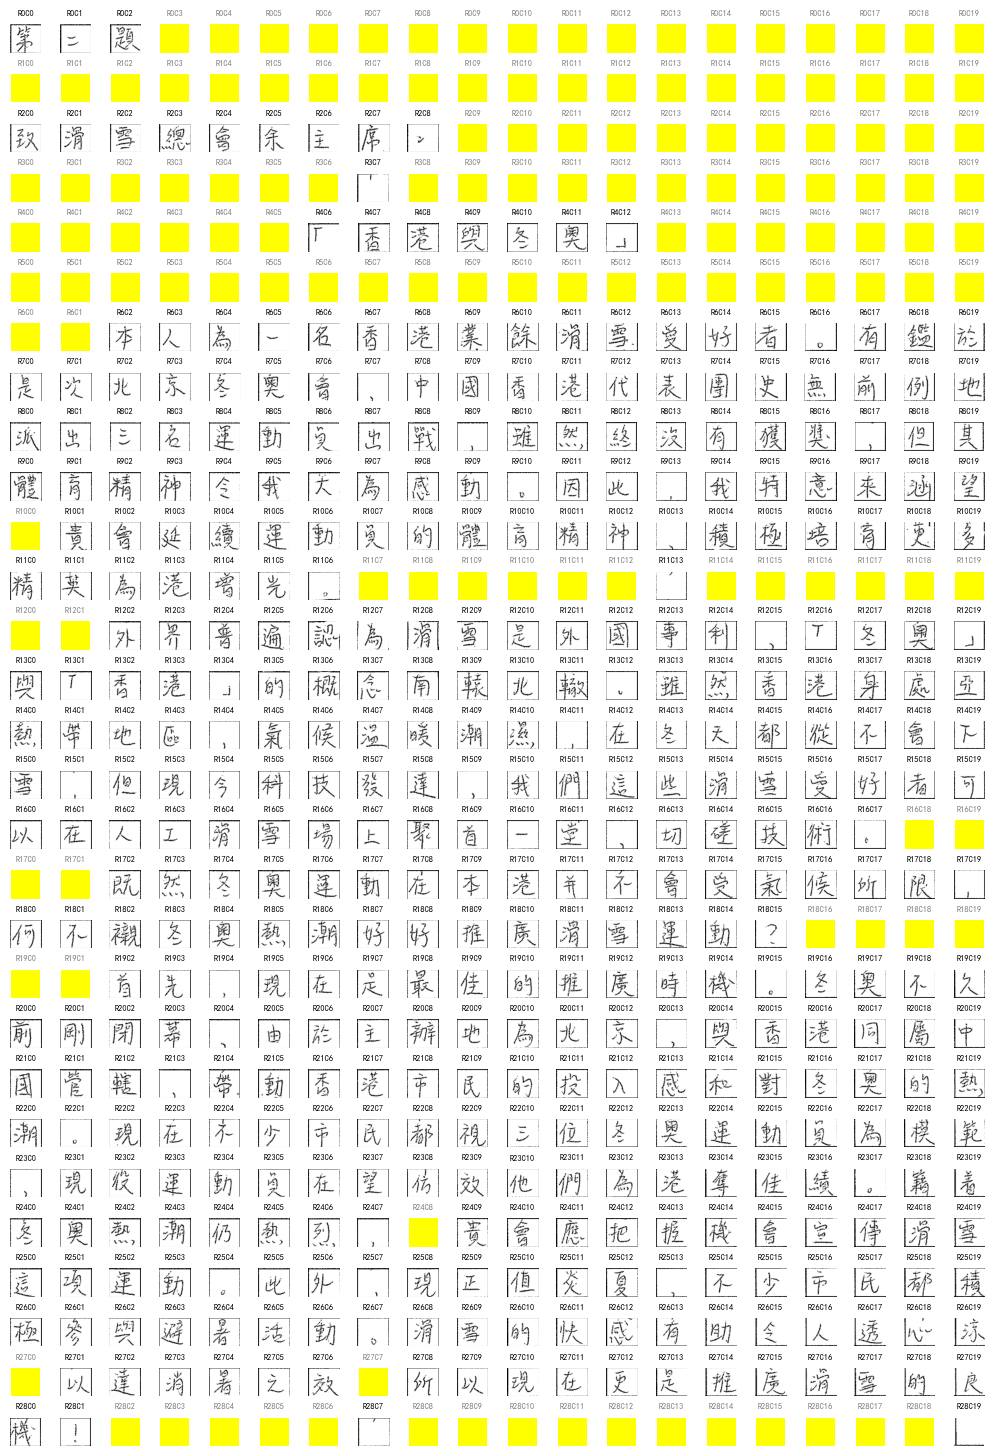


✓ 网格可视化完成
  - 白色格子:非空格子(有内容)
  - 黄色格子:空格子或被过滤的格子


In [5]:
# 可视化格子网格(显示完整布局,空格子用黄色占位)
print("可视化格子网格布局...")

# 获取网格的行列数
rows = max([cell['row'] for cell in cells]) + 1
cols = max([cell['col'] for cell in cells]) + 1

print(f"网格大小: {rows} 行 × {cols} 列")
print(f"总格子数: {len(cells)}")
print(f"非空格子数: {len(cell_images)}")
print(f"空格子数: {len(cells) - len(cell_images)}")

# 创建一个字典,方便根据 (row, col) 查找格子
non_empty_dict = {(cell['row'], cell['col']): idx for idx, cell in enumerate(non_empty_cells)}

# 计算子图布局(限制显示范围,避免过大)
max_display_rows = min(rows, 30)
max_display_cols = min(cols, 30)

if max_display_rows < rows or max_display_cols < cols:
    print(f"⚠️  网格过大,仅显示前 {max_display_rows} 行 × {max_display_cols} 列")

# 创建画布
fig_width = max(10, max_display_cols * 0.5)
fig_height = max(8, max_display_rows * 0.5)
fig, axes = plt.subplots(max_display_rows, max_display_cols, 
                         figsize=(fig_width, fig_height))

# 如果只有一行或一列,确保 axes 是二维数组
if max_display_rows == 1:
    axes = axes.reshape(1, -1)
elif max_display_cols == 1:
    axes = axes.reshape(-1, 1)

# 遍历网格
for row in range(max_display_rows):
    for col in range(max_display_cols):
        ax = axes[row, col]
        ax.axis('off')
        
        # 检查该位置是否有非空格子
        if (row, col) in non_empty_dict:
            # 显示非空格子
            idx = non_empty_dict[(row, col)]
            cell_img = cell_images[idx]
            ax.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
            ax.set_title(f'R{row}C{col}', fontsize=6)
        else:
            # 显示黄色占位符(表示空格子或被过滤的格子)
            yellow_img = np.ones((50, 50, 3)) * np.array([1.0, 1.0, 0.0])  # RGB 黄色
            ax.imshow(yellow_img)
            ax.set_title(f'R{row}C{col}', fontsize=6, color='gray')

plt.tight_layout(pad=0.5)
plt.show()

print(f"\n✓ 网格可视化完成")
print(f"  - 白色格子:非空格子(有内容)")
print(f"  - 黄色格子:空格子或被过滤的格子")

## 4. 辅助函数定义

定义在整个 notebook 中复用的辅助函数

In [6]:
def restore_empty_cells(results_list, cells, non_empty_cells):
    """
    恢复空格子,构建完整的预测结果
    
    参数:
        results_list: OCR识别结果列表(非空格子)
        cells: 所有格子列表(包括空格子)
        non_empty_cells: 非空格子列表
        
    返回:
        prediction_data_full: 完整预测结果(包含空格子)
    """
    # 1. 创建完整的格子字典(包括空格子)
    all_cells_dict = {}
    for cell in cells:
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': '',           # 默认为空
            'confidence': 1.0,    # 空格子置信度设为 1.0
            'is_empty': True      # 标记为空格子
        }
    
    # 2. 填充非空格子的识别结果
    for i, (result, cell) in enumerate(zip(results_list, non_empty_cells)):
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': result.get('text', ''),
            'confidence': result.get('confidence', 0),
            'is_empty': False,
            'ocr_result': result  # 保存完整的 OCR 结果(包含 top_k 等)
        }
    
    # 3. 转换为列表(按 row, col 排序)
    prediction_data_full = sorted(all_cells_dict.values(), 
                                  key=lambda x: (x['row'], x['col']))
    
    return prediction_data_full


def reconstruct_cell_data(metrics_dict):
    """
    从 by_row 结构重构完整的格子列表
    
    参数:
        metrics_dict: GridAccuracyCalculator 返回的结果字典
        
    返回:
        pred_cells: 带元数据的预测格子列表
        gt_cells: Ground Truth 文本列表
    """
    pred_cells = []
    gt_cells = []
    
    for row_result in metrics_dict['by_row']:
        row_idx = row_result['row']
        for col_idx, (pred_text, gt_text, conf) in enumerate(
            zip(row_result['pred_cells'], row_result['gt_cells'], 
                row_result['confidences'])
        ):
            pred_cells.append({
                'row': row_idx,
                'col': col_idx,
                'text': pred_text,
                'confidence': conf,
                'is_empty': (pred_text == '')
            })
            gt_cells.append({
                'row': row_idx,
                'col': col_idx,
                'text': gt_text
            })
    
    return pred_cells, gt_cells


def display_row_comparison(row_idx, pred_cells, gt_cells, enhanced_cells=None):
    """
    显示单行的对比(原始预测 vs Ground Truth vs 增强预测)
    
    参数:
        row_idx: 行索引
        pred_cells: 原始预测的格子列表
        gt_cells: Ground Truth 的格子列表
        enhanced_cells: 增强预测的格子列表(可选)
    """
    print(f"\n{'='*80}")
    print(f"第 {row_idx} 行对比")
    print(f"{'='*80}")
    
    # 获取该行的格子
    pred_row = [c for c in pred_cells if c['row'] == row_idx]
    gt_row = [c for c in gt_cells if c['row'] == row_idx]
    
    # 对齐到相同长度
    max_len = max(len(pred_row), len(gt_row))
    
    # 打印表头
    print(f"{'Col':<5} {'预测':<10} {'GT':<10}", end='')
    if enhanced_cells:
        enhanced_row = [c for c in enhanced_cells if c['row'] == row_idx]
        print(f" {'增强':<10} {'改变':<6}", end='')
    print(f" {'匹配':<6}")
    print(f"{'-'*80}")
    
    # 打印每列
    for col in range(max_len):
        pred_text = pred_row[col]['text'] if col < len(pred_row) else ''
        gt_text = gt_row[col]['text'] if col < len(gt_row) else ''
        
        # 判断是否匹配
        is_match = (pred_text == gt_text)
        match_str = '✓' if is_match else '✗'
        
        print(f"{col:<5} {pred_text:<10} {gt_text:<10}", end='')
        
        if enhanced_cells and col < len(enhanced_row):
            enhanced_text = enhanced_row[col]['text']
            is_changed = (enhanced_text != pred_text)
            changed_str = '→' if is_changed else ''
            enhanced_match = (enhanced_text == gt_text)
            enhanced_match_str = '✓' if enhanced_match else '✗'
            print(f" {enhanced_text:<10} {changed_str:<6}", end='')
            print(f" {match_str} → {enhanced_match_str}")
        else:
            print(f" {match_str}")
    

print(f"{'-'*80}")


print("✓ 辅助函数定义完成")

--------------------------------------------------------------------------------
✓ 辅助函数定义完成


## 5. 全局处理器初始化

创建共享的处理器实例,在整个 notebook 中复用(避免重复加载 BERT 模型)

In [7]:
# 导入处理器
from src.custom_ocr.processors.grid_context_enhancer import GridContextEnhancer

# 初始化共享的处理器实例
print("初始化全局处理器...")

# 1. Top-K 解码器
decoder = TopKDecoder(k=5)
print("✓ Top-K 解码器 (k=5)")

# 2. CTC 去重器
deduplicator = CTCDeduplicator()
print("✓ CTC 去重器")

# 3. 置信度过滤器
conf_filter = ConfidenceFilter(threshold=0.3)
print("✓ 置信度过滤器 (threshold=0.3)")

# 4. 格子级 BERT 增强器
grid_enhancer = GridContextEnhancer(
    model_name='bert-base-chinese',
    device='cuda:0',  # 如果没有 GPU,改为 'cpu'
    context_window=10,    # 上下文窗口:前后各5个格子
    confidence_threshold=0.8  # 低于此置信度的格子才会被BERT增强
)
print("✓ 格子级 BERT 增强器")
print(f"  - 模型: {grid_enhancer.model_name}")
print(f"  - 设备: {grid_enhancer.device}")
print(f"  - 窗口大小: {grid_enhancer.context_window}")
print(f"  - 置信度阈值: {grid_enhancer.confidence_threshold}")

print("\n所有处理器初始化完成!")

初始化全局处理器...
✓ Top-K 解码器 (k=5)
✓ CTC 去重器
✓ 置信度过滤器 (threshold=0.3)
✓ GridContextEnhancer 初始化完成
  模型: bert-base-chinese
  上下文窗口: ±10 个格子
  融合权重: 60.0% OCR + 40.0% BERT
  设备: cuda:0
✓ 格子级 BERT 增强器
  - 模型: bert-base-chinese
  - 设备: cuda:0
  - 窗口大小: 10
  - 置信度阈值: 0.8

所有处理器初始化完成!


---
# Part 2: 原始 OCR Pipeline(方法链式调用)
---

## 6. 批量处理所有格子(方法链式调用)

使用**方法链式调用**(而非 Pipeline),每一步的输出都可见

In [8]:
# 批量处理所有格子
print("批量处理所有格子...")
print("="*80)

# 步骤 1: 获取原始概率矩阵(批量)
print("\n步骤 1: 获取原始概率矩阵...")
batch_raw_outputs = recognizer.batch_predict_with_raw_output(cell_images)
print(f"✓ 获取 {len(batch_raw_outputs)} 个格子的概率矩阵")

# 步骤 2: 方法链式调用(每步可见)
print("\n步骤 2: 执行后处理...")
results_list = []

for i, raw_output in enumerate(batch_raw_outputs):
    # 2.1 Top-K 解码
    decoded = decoder(raw_output)
    
    # 2.2 CTC 去重
    deduped = deduplicator(decoded)
    
    # 2.3 置信度过滤
    filtered = conf_filter(deduped)
    
    results_list.append(filtered)
    
    # 打印前10个格子的结果
    if i < 10:
        text = filtered.get('text', '')
        confidence = filtered.get('confidence', 0)
        print(f"  格子 {i+1:3d}: '{text:8s}' (置信度: {confidence:.3f})")

print(f"\n✓ 处理完成!共处理 {len(results_list)} 个非空格子")

# 步骤 3: 恢复空格子
print("\n步骤 3: 恢复空格子...")
prediction_data_full = restore_empty_cells(results_list, cells, non_empty_cells)

print(f"✓ 完整预测结果: {len(prediction_data_full)} 个格子")
print(f"  - 非空格子: {len([c for c in prediction_data_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in prediction_data_full if c['is_empty']])} 个")

# 验证:显示第一行的格子分布
first_row_cells = [c for c in prediction_data_full if c['row'] == 0]
print(f"\n第一行格子分布(共 {len(first_row_cells)} 个):")
for cell in first_row_cells[:10]:  # 只显示前10个
    status = "空" if cell['is_empty'] else f"'{cell['text']}'"
    print(f"  col {cell['col']}: {status}")

批量处理所有格子...

步骤 1: 获取原始概率矩阵...
✓ 获取 434 个格子的概率矩阵

步骤 2: 执行后处理...
  格子   1: '第       ' (置信度: 1.000)
  格子   2: '=       ' (置信度: 0.625)
  格子   3: '题       ' (置信度: 0.705)
  格子   4: '致       ' (置信度: 0.987)
  格子   5: '滑       ' (置信度: 0.998)
  格子   6: '雪       ' (置信度: 0.990)
  格子   7: '總       ' (置信度: 0.983)
  格子   8: '會       ' (置信度: 0.881)
  格子   9: '余       ' (置信度: 0.987)
  格子  10: '主       ' (置信度: 0.999)

✓ 处理完成!共处理 434 个非空格子

步骤 3: 恢复空格子...
✓ 完整预测结果: 580 个格子
  - 非空格子: 434 个
  - 空格子: 146 个

第一行格子分布(共 20 个):
  col 0: '第'
  col 1: '='
  col 2: '题'
  col 3: 空
  col 4: 空
  col 5: 空
  col 6: 空
  col 7: 空
  col 8: 空
  col 9: 空


In [9]:
# ''.join([each for each in results_list])
data = [[each['row'], each['col'], each['text']] for each in prediction_data_full]
current_row = None
line = []
for r, c, val in data:
    if current_row is None:
        current_row = r
    if r != current_row:
        print(''.join(line))  # 或者 print(' '.join(line)) 看你是否需要分隔符
        line = []
        current_row = r
    line.append(str(val) if val != '' else '□')  # 用 □ 表示空格子
# 打印最后一行
if line:
    print(''.join(line))

第=题□□□□□□□□□□□□□□□□□
□□□□□□□□□□□□□□□□□□□□
致滑雪總會余主序2□□□□□□□□□□□
□□□□□□□□□□□□□□□□□□□□
□□□□□□厂香港舆冬奥日□□□□□□□
□□□□□□□□□□□□□□□□□□□□
□□本人為一名香港業餘滑雪爱好者。有金於
是次北京冬奥會、中國香港代表團史無前例地
派出三名運動员出戰□雖然終没有獲獎国但其
體育精神令我大為感動。因此□我特意來涵望
□贵會延續運動员的體育精神国積極培育更多
精英為港增光□□□□□□□□□□□□□□
□□外界普遍認為滑雪是外國專利国T冬奥日
與T香港口的概念南轅北□。班然香港身處亞
热带地□,氣候温暖潮□□在冬天都從不會下
雪□但現今科技發達,我们這些滑雪爱好者可
以在人工滑雪場上聚首-堂□切磋技行e□□
□□既然冬奥運動在本港并不會受氣候所限□
何不襯冬奥熱潮好好推廣滑雪運動2□□□□
□□首先,現在是最佳的推廣時機。冬奥不久
前剛閉幕□由於主辩地為北京□明香港同屬中
國管轄□带.動香港市民的投入感和對冬奥的熱
潮。現在不少市民都视三位冬奥運動力真為模範
□現役運動莫在望仿效他們為港奪佳績。籍着
冬奥热潮仍热烈□□贵會應把握機會宣傳滑雪
這项運動□此外□现正值炎夏□不少市民都積
極参與避暑活動。滑雪的快感有助令人透心凉
□以達消暑之效□所以現在更是推廣滑雪的良
機1□□□□□□□□□□□□□□□□□国


## 7. 原始 OCR 准确率评估

In [10]:
# 导入自定义评估模块
from src.evaluation import GridAccuracyCalculator

# 创建计算器实例
calculator = GridAccuracyCalculator(empty_char='')

# 计算准确率
print("计算原始 OCR 准确率...")
print("="*80)

metrics = calculator.calculate(
    predicted_results=prediction_data_full,
    ground_truth=ground_truth,
    align_by_row=True
)

# 打印结果
print("\n原始 OCR 准确率:")
print(f"  字符准确率: {metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {metrics['overall']['matched_chars']}")
print(f"  总字符数: {metrics['overall']['total_chars']}")
print(f"  格子匹配数: {sum(r['cell_matches'] for r in metrics['by_row'])}")
print(f"  总格子数: {sum(r['total_cells'] for r in metrics['by_row'])}")

if 'by_row' in metrics:
    print(f"\n按行统计:")
    for row_info in metrics['by_row'][:10]:  # 显示前10行
        print(f"  第 {row_info['row']} 行: {row_info['cell_matches']}/{row_info['total_cells']} "
              f"({row_info['accuracy']:.2f}%)")

pred_cells, gt_cells = reconstruct_cell_data(metrics)
# 重构完整的格子数据(供后续分析使用)

计算原始 OCR 准确率...

原始 OCR 准确率:
  字符准确率: 80.32%
  正确字符数: 347
  总字符数: 432
  格子匹配数: 482
  总格子数: 580

按行统计:
  第 0 行: 18/20 (90.00%)
  第 1 行: 20/20 (100.00%)
  第 2 行: 18/20 (90.00%)
  第 3 行: 20/20 (100.00%)
  第 4 行: 16/20 (80.00%)
  第 5 行: 20/20 (100.00%)
  第 6 行: 18/20 (90.00%)
  第 7 行: 18/20 (90.00%)
  第 8 行: 15/20 (75.00%)
  第 9 行: 18/20 (90.00%)


## 8. 识别错误分析

In [11]:
# 分析识别错误
print("识别错误分析")
print("="*80)

if 'by_row' not in metrics:
    print("⚠️  缺少详细对比数据,无法分析错误")
else:
    # 使用已重构的格子数据(在 Section 7 中生成)
    
    # 统计错误类型
    error_count = 0
    low_conf_errors = []
    high_conf_errors = []
    
    for pred, gt in zip(pred_cells, gt_cells):
        if pred['text'] != gt['text']:
            error_count += 1
            conf = pred.get('confidence', 0)
            if conf < 0.6:
                low_conf_errors.append((pred, gt['text'], conf))
            else:
                high_conf_errors.append((pred, gt['text'], conf))
    
    print(f"\n总错误数: {error_count}")
    print(f"  低置信度错误 (<0.6): {len(low_conf_errors)}")
    print(f"  高置信度错误 (≥0.6): {len(high_conf_errors)}")
    
    # 显示低置信度错误示例
    if low_conf_errors:
        print(f"\n低置信度错误示例(前10个):")
        for i, (pred, gt, conf) in enumerate(low_conf_errors[:10]):
            print(f"  {i+1}. '{pred['text']}' → '{gt}' (置信度: {conf:.3f}, "
                  f"位置: R{pred['row']}C{pred['col']})")
    
    # 显示高置信度错误示例
    if high_conf_errors:
        print(f"\n高置信度错误示例(前5个):")
        for i, (pred, gt, conf) in enumerate(high_conf_errors[:5]):
            print(f"  {i+1}. '{pred['text']}' → '{gt}' (置信度: {conf:.3f}, "
                  f"位置: R{pred['row']}C{pred['col']})")

识别错误分析

总错误数: 98
  低置信度错误 (<0.6): 45
  高置信度错误 (≥0.6): 53

低置信度错误示例(前10个):
  1. '2' → '：' (置信度: 0.561, 位置: R2C8)
  2. '舆' → '與' (置信度: 0.597, 位置: R4C9)
  3. '日' → '」' (置信度: 0.280, 位置: R4C12)
  4. '员' → '員' (置信度: 0.312, 位置: R8C6)
  5. '' → '，' (置信度: 0.000, 位置: R8C9)
  6. '国' → '，' (置信度: 0.380, 位置: R8C17)
  7. '' → '，' (置信度: 0.000, 位置: R9C13)
  8. '员' → '員' (置信度: 0.527, 位置: R10C7)
  9. '国' → '，' (置信度: 0.536, 位置: R10C13)
  10. '' → '。' (置信度: 0.000, 位置: R11C6)

高置信度错误示例(前5个):
  1. '=' → '二' (置信度: 0.625, 位置: R0C1)
  2. '题' → '題' (置信度: 0.705, 位置: R0C2)
  3. '序' → '席' (置信度: 0.845, 位置: R2C7)
  4. '厂' → '「' (置信度: 0.634, 位置: R4C6)
  5. '奥' → '奧' (置信度: 0.655, 位置: R4C11)


## 9. Top-K 分析(找出 BERT 增强的潜力)

In [12]:
# Top-K 分析:正确答案在 Top-K 中的比例
print("Top-K 分析:正确答案在候选中的比例")
print("="*80)

if 'by_row' not in metrics:
    print("⚠️  缺少详细对比数据")
else:
    # 使用已重构的格子数据(在 Section 7 中生成)
    
    # 统计 Top-K 包含正确答案的情况
    top1_correct = 0
    top_k_contains_answer = 0
    total_errors = 0
    
    for pred_cell_data, gt in zip(pred_cells, gt_cells):
        pred_text = pred_cell_data['text']
        gt_text = gt['text']
        
        # 只分析非空格子
        if pred_cell_data.get('is_empty', False):
            continue
        
        if pred_text != gt_text:
            total_errors += 1
            
            # 检查 Top-K 候选
            if 'ocr_result' in pred_cell_data:
                ocr_result = pred_cell_data['ocr_result']
                if 'top_k_chars' in ocr_result and len(ocr_result['top_k_chars']) > 0:
                    # 获取第一个时间步的 Top-K(通常是主要字符)
                    top_k_chars = ocr_result['top_k_chars'][0]
                    if len(top_k_chars) > 0 and gt_text in top_k_chars[0]:
                        top_k_contains_answer += 1
        else:
            top1_correct += 1
    
    print(f"\n总格子数(非空): {len([c for c in pred_cells if not c.get('is_empty', False)])}")
    print(f"Top-1 正确: {top1_correct}")
    print(f"Top-1 错误: {total_errors}")
    print(f"  其中 Top-K 包含正确答案: {top_k_contains_answer}")
    
    if total_errors > 0:
        potential_improvement = top_k_contains_answer / total_errors
        print(f"\nBERT 增强潜力: {potential_improvement:.2%}")
        print(f"  (有 {top_k_contains_answer}/{total_errors} 个错误可能通过 BERT 上下文纠正)")
    
    # 最佳可能准确率
    if len([c for c in pred_cells if not c.get('is_empty', False)]) > 0:
        best_possible = (top1_correct + top_k_contains_answer) / len([c for c in pred_cells if not c.get('is_empty', False)])
        print(f"\n最佳可能准确率(如果 BERT 完美纠正): {best_possible:.2%}")

Top-K 分析:正确答案在候选中的比例

总格子数(非空): 413
Top-1 正确: 336
Top-1 错误: 77
  其中 Top-K 包含正确答案: 0

BERT 增强潜力: 0.00%
  (有 0/77 个错误可能通过 BERT 上下文纠正)

最佳可能准确率(如果 BERT 完美纠正): 81.36%


---
# Part 3: 格子级 BERT 增强
---

## 10. 批量 BERT 增强(格子级)

使用**格子级 BERT 增强器**批量处理所有非空格子

In [13]:
# 批量 BERT 增强(使用全局共享的 grid_enhancer)
print("批量 BERT 增强...")
print("="*80)

# 使用格子级 BERT 增强器
enhanced_results_list = grid_enhancer.enhance_grids(
    grid_results=results_list,
    grid_indices=None  # None 表示处理所有格子
)

print(f"✓ 增强完成!共处理 {len(enhanced_results_list)} 个格子")

# 统计增强效果
changed_count = 0
for original, enhanced in zip(results_list, enhanced_results_list):
    if original.get('text', '') != enhanced.get('text', ''):
        changed_count += 1

print(f"\n增强统计:")
print(f"  改变的格子数: {changed_count}")
print(f"  改变率: {changed_count/len(results_list):.2%}")

# 显示前10个改变的格子
print(f"\n前10个改变的格子:")
shown = 0
for i, (original, enhanced) in enumerate(zip(results_list, enhanced_results_list)):
    if original.get('text', '') != enhanced.get('text', ''):
        print(f"  格子 {i+1}: '{original.get('text', '')}' → '{enhanced.get('text', '')}' "
              f"(置信度: {original.get('confidence', 0):.3f} → "
              f"{enhanced.get('confidence', 0):.3f})")
        shown += 1
        if shown >= 10:
            break

# 恢复空格子
print(f"\n恢复空格子...")
enhanced_prediction_data_full = restore_empty_cells(
    enhanced_results_list, cells, non_empty_cells
)

print(f"✓ 完整增强预测结果: {len(enhanced_prediction_data_full)} 个格子")
print(f"  - 非空格子: {len([c for c in enhanced_prediction_data_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in enhanced_prediction_data_full if c['is_empty']])} 个")

批量 BERT 增强...
正在加载 BERT 模型: bert-base-chinese...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ BERT 模型加载成功

自动识别到 114 个低置信度格子需要增强

✓ 格子级增强完成: 检查了 114 个格子，修正了 18 个
✓ 增强完成!共处理 434 个格子

增强统计:
  改变的格子数: 18
  改变率: 4.15%

前10个改变的格子:
  格子 68: '' → '，' (置信度: 0.000 → 0.360)
  格子 92: '' → '，' (置信度: 0.000 → 0.452)
  格子 124: '' → '彩' (置信度: 0.000 → 0.190)
  格子 125: '' → '彩' (置信度: 0.000 → 0.228)
  格子 155: '' → '轍' (置信度: 0.000 → 0.443)
  格子 167: '' → '区' (置信度: 0.000 → 0.334)
  格子 174: '' → '濕' (置信度: 0.000 → 0.407)
  格子 175: '' → '濕' (置信度: 0.000 → 0.430)
  格子 185: '' → ',' (置信度: 0.000 → 0.411)
  格子 216: '' → '堂' (置信度: 0.000 → 0.354)

恢复空格子...
✓ 完整增强预测结果: 580 个格子
  - 非空格子: 434 个
  - 空格子: 146 个


## 11. 增强后准确率评估

In [14]:
# 计算增强后的准确率
print("计算增强后准确率...")
print("="*80)

enhanced_metrics = calculator.calculate(
    predicted_results=enhanced_prediction_data_full,
    ground_truth=ground_truth,
    align_by_row=True
)

# 打印结果
print("\n增强后准确率:")
print(f"  字符准确率: {enhanced_metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {enhanced_metrics['overall']['matched_chars']}")
print(f"  总字符数: {enhanced_metrics['overall']['total_chars']}")
print(f"  格子匹配数: {sum(r['cell_matches'] for r in enhanced_metrics['by_row'])}")
print(f"  总格子数: {sum(r['total_cells'] for r in enhanced_metrics['by_row'])}")

# 重构增强后的格子数据
enhanced_cells, _ = reconstruct_cell_data(enhanced_metrics)

# 对比原始和增强后的准确率
print(f"\n{'='*80}")
print("准确率对比")
print(f"{'='*80}")
print(f"{'指标':<20} {'原始':<15} {'增强':<15} {'提升':<15}")
print(f"{'-'*80}")
print(f"{'字符准确率':<20} {metrics['overall']['accuracy']:<15.2f}% "
      f"{enhanced_metrics['overall']['accuracy']:<15.2f}% "
      f"{enhanced_metrics['overall']['accuracy'] - metrics['overall']['accuracy']:<15.2f}%")
print(f"{'正确字符数':<20} {metrics['overall']['matched_chars']:<15} "
      f"{enhanced_metrics['overall']['matched_chars']:<15} "
      f"{enhanced_metrics['overall']['matched_chars'] - metrics['overall']['matched_chars']:<15}")

orig_cell_matches = sum(r['cell_matches'] for r in metrics['by_row'])
enh_cell_matches = sum(r['cell_matches'] for r in enhanced_metrics['by_row'])

print(f"{'格子匹配数':<20} {orig_cell_matches:<15} "
      f"{enh_cell_matches:<15} "
      f"{enh_cell_matches - orig_cell_matches:<15}")

计算增强后准确率...

增强后准确率:
  字符准确率: 83.10%
  正确字符数: 359
  总字符数: 432
  格子匹配数: 493
  总格子数: 580

准确率对比
指标                   原始              增强              提升             
--------------------------------------------------------------------------------
字符准确率                80.32          % 83.10          % 2.78           %
正确字符数                347             359             12             
格子匹配数                482             493             11             


## 12. 保存结果(纯文本格式)

**【修改点】**: 保存简单的文本文件,而不是复杂的JSON格式

In [16]:
def extract_prediction_text_with_spacing(prediction_data_full):
    """
    从预测数据中提取文本,保留所有空格(包括行首、行中、行尾)
    
    参数:
        prediction_data_full: 完整的预测结果(包含空格子)
        
    返回:
        text: 格式化的文本字符串(保留所有空格)
    """
    # 按行分组
    rows_dict = {}
    for cell in prediction_data_full:
        row = cell['row']
        if row not in rows_dict:
            rows_dict[row] = []
        rows_dict[row].append(cell)
    
    # 按行号排序
    sorted_rows = sorted(rows_dict.items())
    
    # 构建文本
    lines = []
    for row_idx, row_cells in sorted_rows:
        # 按列号排序
        sorted_cells = sorted(row_cells, key=lambda x: x['col'])
        
        # 构建该行文本(空格子用空格' '表示)
        row_text = ''
        for cell in sorted_cells:
            if cell['is_empty']:
                row_text += ' '  # 空格子用空格表示
            else:
                row_text += cell['text']
        
        lines.append(row_text)
    
    return '\n'.join(lines)


def save_prediction_text(prediction_data_full, raw_img_path, mode='original'):
    """
    保存预测文本,保留目录结构
    
    参数:
        prediction_data_full: 完整的预测结果
        raw_img_path: 原始图像路径 (Path对象)
        mode: 'original' 或 'enhanced'
        
    返回:
        output_path: 保存的文件路径
    """
    # 提取文本
    pred_text = extract_prediction_text_with_spacing(prediction_data_full)
    
    # 构建输出路径
    project_root = Path('..').resolve()
    samples_dir = project_root / 'data' / 'samples'
    
    # 获取相对路径(相对于samples目录)
    try:
        relative_path = raw_img_path.relative_to(samples_dir)
    except ValueError:
        # 如果不在samples目录下,使用默认路径
        relative_path = Path('default') / raw_img_path.name
    
    # 构建输出目录(保留主题文件夹结构)
    output_base = project_root / 'output' / 'predictions'
    topic_folder = relative_path.parent  # 获取主题文件夹名
    output_dir = output_base / topic_folder
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 构建输出文件名
    img_stem = raw_img_path.stem  # 例如 'sample_04_01'
    output_filename = f"{img_stem}_{mode}.txt"
    output_path = output_dir / output_filename
    
    # 保存文本
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(pred_text)
    
    return output_path


# 保存原始预测和增强预测
print("保存预测结果...")
print("="*80)

# 1. 保存原始预测
original_path = save_prediction_text(prediction_data_full, raw_img_path, mode='original')
print(f"✓ 原始预测已保存到: {original_path}")

# 2. 保存增强预测
enhanced_path = save_prediction_text(enhanced_prediction_data_full, raw_img_path, mode='enhanced')
print(f"✓ 增强预测已保存到: {enhanced_path}")

# 3. 显示保存的文件信息
print(f"\n文件信息:")
print(f"  原始预测: {original_path.stat().st_size} 字节")
print(f"  增强预测: {enhanced_path.stat().st_size} 字节")

# 4. 显示前5行预览
print(f"\n原始预测前5行预览:")
with open(original_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(f"  行{i+1}: {repr(line.rstrip())}")  # 使用repr显示空格

print(f"\n增强预测前5行预览:")
with open(enhanced_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(f"  行{i+1}: {repr(line.rstrip())}")

# 5. 总结
print(f"\n{'='*80}")
print("处理总结")
print(f"{'='*80}")
print(f"  原图 → 裁剪 → 格子检测 → OCR识别 → BERT增强")
print(f"  原始准确率: {metrics['overall']['accuracy']:.2f}%")
print(f"  增强准确率: {enhanced_metrics['overall']['accuracy']:.2f}%")
print(f"  提升: +{enhanced_metrics['overall']['accuracy'] - metrics['overall']['accuracy']:.2f}%")
print(f"\n  输出目录: {project_root / 'output' / 'predictions'}")
print(f"  - {original_path.name}")
print(f"  - {enhanced_path.name}")

保存预测结果...
✓ 原始预测已保存到: C:\Users\Quenton\Documents\Github\writtingOCR\output\predictions\2022 第2題 (冬奧) (8份)_Original\sample_04_01_original.txt
✓ 增强预测已保存到: C:\Users\Quenton\Documents\Github\writtingOCR\output\predictions\2022 第2題 (冬奧) (8份)_Original\sample_04_01_enhanced.txt

文件信息:
  原始预测: 1423 字节
  增强预测: 1475 字节

原始预测前5行预览:
  行1: '第=题'
  行2: ''
  行3: '致滑雪總會余主序2'
  行4: ''
  行5: '      厂香港舆冬奥日'

增强预测前5行预览:
  行1: '第=题'
  行2: ''
  行3: '致滑雪總會余主序2'
  行4: ''
  行5: '      厂香港舆冬奥日'

处理总结
  原图 → 裁剪 → 格子检测 → OCR识别 → BERT增强
  原始准确率: 80.32%
  增强准确率: 83.10%
  提升: +2.78%

  输出目录: C:\Users\Quenton\Documents\Github\writtingOCR\output\predictions
  - sample_04_01_original.txt
  - sample_04_01_enhanced.txt
